# Calculate X, Y, Z Real World Coordinates from Image Coordinates using OpenCV and Structured Light

### Notebook by [André Madureira](https://github.com/Andremad-03), [José Guerra](https://github.com/LockDownPT), [Luis Ramos](https://github.com/luispramos), [Martim Pinto da Silva](https://github.com/motapinto)
#### [Faculdade de Engenharia da Universidade do Porto](https://sigarra.up.pt/feup/en/web_page.inicial)

#### It is recommended to [view this notebook in nbviewer]() for the best overall experience
#### You can also execute the code on this notebook using [Jupyter Notebook](https://jupyter.org/), [Binder](https://mybinder.org/) or [Google Colab](https://colab.research.google.com/) (no local installation required)

## Table of contents
1. * [Introduction](#Introduction)
2. * [Required libraries](#Required-libraries)
4. * [Camera calibration](#Camera-calibration)
        - [Intrinsic parameters](#Intrinsic-parameters)
        - [Extrinsic parameters](#Extrinsic-parameters)
5. * [Re-projection Error](#Re-projection-Error)
6. * [Undistortion](#Undistortion)
7. * [Perspective Projection Matrix](#Perspective-Projection-Matrix)
8. * [Line Detection](#Line-Detection)
9. * [Resources](#Resources)

## Introduction
[go back to the top](#Table-of-contents)

Structured light techniques for 3D data acquisition play a central role in many 3D data acquisition applications, namelly when the surfaces to be measured do not have feature points or when it is necessary to obtain
dense 3D data. They are used in numerous applications: industrial (ex: dimensional control or quality
inspection), reverse engineering, urban (ex: road inspection) and medical, are just a few examples. 

These techniques are based on the acquisition of an image of a scene over which a light pattern is projected; this
pattern ranges from a single light ray or a single light sheet to a set of parallel sheets or a pseudo-random
pattern. Frequently, laser light is used to simplify the detection of the projected patterns.

In this work we will have the opportunity of implementing a 3D data acquisition system based on structured
light, using a single sheet of light/shadow

## Required libraries
[go back to the top](#Table-of-contents)

The primary libraries that we'll be using are:

* numpy: Provides a fast numerical array structure and helper functions.
* cv2: OpenCV provides a real-time optimized Computer Vision library, tools, and hardware.
* glob: Is used to retrieve files/pathnames matching a specified pattern.
* matplotlib: Basic plotting library in Python, with capabilities of showing images.
* sympy: Library for symbolic mathematics and for solving equations.

In [63]:
import os
import numpy as np
import cv2
import glob
import math
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, poly

In [64]:
# number of interior squares of chess Board
n_grid = 7

# chessboard square size in cm
square_size = 2.5

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((n_grid*n_grid,3), np.float32)
objp[:,:2] = np.mgrid[0:n_grid,0:n_grid].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj_points = [] # 3d point in real world space
img_points = [] # 2d points in image plane.

line_detection_path = 'images/lineDetection'
calibration_path = 'images/calibration'
calibration_images = glob.glob(os.path.join(calibration_path,'*.JPG'))

## Camera calibration

### Intrinsic parameters

Intrinsic parameters are specific to a camera. They include information like focal length (fx,fy) and optical centers (cx,cy). The focal length and optical centers can be used to create a camera matrix, which can be used to remove distortion due to the lenses of a specific camera. The camera matrix is unique to a specific camera, so once calculated, it can be reused on other images taken by the same camera. 


### Extrinsic parameters

Extrinsic parameters corresponds to rotation and translation vectors which translates a coordinates of a 3D point to a coordinate system.

In [65]:
for fname in calibration_images:
    img = cv2.imread(fname)

    # TODO: Why do we put thin in gray? Does it affect results?
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(img, (n_grid,n_grid), None)

    # If found, add object points, image points (after refining them)
    if ret:
        obj_points.append(objp)
        img_point = cv2.cornerSubPix(gray, corners, (11, 11), (-1,-1), criteria)
        img_points.append(img_point)

# After acquiring the object and image points we need to calibrate the camera. For that we use the function, cv2.calibrateCamera() that returns the camera matrix, distortion coefficients, rotation and translation vectors.
_, camera_matrix, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

## Re-projection Error

Re-projection error gives a good estimation of just how exact the found parameters are. The closer the re-projection error is to zero, the more accurate the parameters we found are.

In [66]:
total_error = 0
for i in range(len(obj_points)):
    img_points_tes, _  = cv2.projectPoints(obj_points[i], rvecs[i], tvecs[i], camera_matrix, dist)
    error = cv2.norm(src1=img_points[i], src2=img_points_tes, normType=cv2.NORM_L2) / len(img_points_tes)
    total_error += error

print("mean error: {}".format(total_error / len(obj_points)))

mean error: 0.10136237368636154


## Undistortion

Now we can take an image and undistort it using the distortion coeficients.

In [67]:
imgcal = cv2.imread(os.path.join('images', 'img_cal.jpg'))
h,  w = imgcal.shape[:2]
new_camera_mtx, roi=cv2.getOptimalNewCameraMatrix(camera_matrix, dist, (w,h), 1, (w,h))

# undistort
undst = cv2.undistort(imgcal, camera_matrix, dist, None, new_camera_mtx)

# crop the image
x,y,w,h = roi
undst = undst[y:y+h, x:x+w]
cv2.imwrite('images/calibresult.png', undst)

True

## Perspective Projection Matrix
We create the Perspective Projection Matrix using the Camera Matrix (obtained in the function calibrateCamera), the
Rotation Matrix (which we are going to calculate using Rodrigues function), and the Translation Vector (later obtained in the SolvePnP function), where all these functions are a part of the cv2 library

In [68]:
#The draw function implemented next draws the reference axis in our selected image
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

<ipython-input-68-375332cd5fbf>:4: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
<ipython-input-68-375332cd5fbf>:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
<ipython-input-68-375332cd5fbf>:6: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)


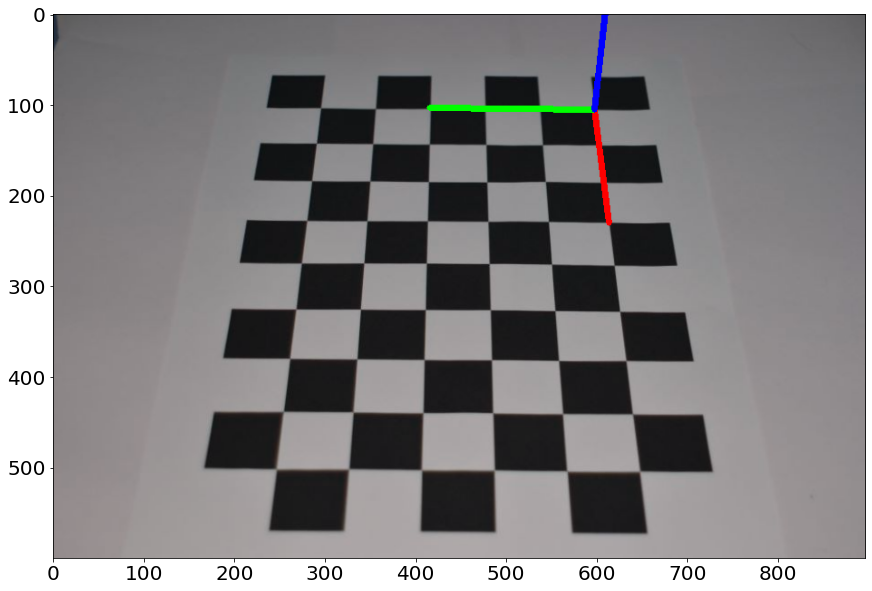

In [69]:
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
#The np.zeros matrix was changed from (n_grid, n_grid) = (7,7) to (9,6)
#because the new chessboard image has 9*6 inners corners
objp2 = np.zeros((9*6,3), np.float32)
objp2[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj_points2 = [] # 3d point in real world space
img_points2 = [] # 2d points in image plane.

gray = cv2.cvtColor(undst, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
if ret:
    corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
    # Find the rotation and translation vectors.
    ret, rvecs1, tvecs1, inlier = cv2.solvePnPRansac(objp2, corners2, camera_matrix, dist)

    # project 3D reference into image plane
    imgpts, jac = cv2.projectPoints(axis, rvecs1, tvecs1, camera_matrix, dist)
    ref_img = draw(undst, corners, imgpts)
    plt.imshow(ref_img)
    plt.show()
    rotM, _= cv2.Rodrigues(rvecs1)

In [70]:
#Prespective Projection Matrix -
K = new_camera_mtx

#In this block, we homogenize the matrices that are going to be a part of the Prespective Projection Matrix (PPMatrix) because
# Using homogeneous coordinates, Rotation and Translation can be expressed by a single matrix
Homog_K = np.array([[K[0][0], K[0][1], K[0][2], 0], [K[1][0], K[1][1], K[1][2], 0], [K[2][0], K[2][1], K[2][2], 0]])
Homog_R = np.array([[rotM[0][0], rotM[0][1], rotM[0][2], 0],[rotM[1][0], rotM[1][1], rotM[1][2], 0], [rotM[2][0], rotM[2][1], rotM[2][2], 0],[0, 0, 0, 1]])
Homog_T = np.array([[1, 0, 0, tvecs1[0][0]],[0, 1, 0, tvecs1[1][0]], [0, 0, 1, tvecs1[2][0]], [0, 0, 0, 1]])
Homog_Ext = np.matmul(Homog_T, Homog_R)
PPMatrix = np.matmul(Homog_K, Homog_Ext)

## Line Detection

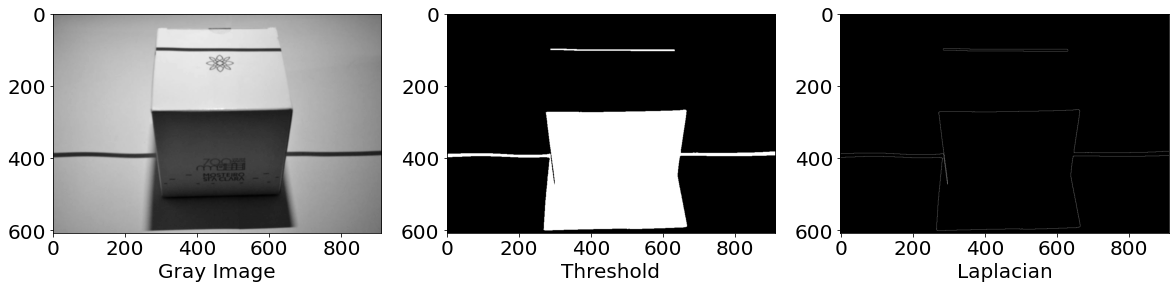

In [80]:
# Gray image
img_shadow_plane = cv2.imread(os.path.join(line_detection_path, 'img4.JPG'))
gray = cv2.cvtColor(img_shadow_plane, cv2.COLOR_BGR2GRAY)

gray = cv2.GaussianBlur(gray, (5,5), 0)

# Threshold
low_threshold = 80
high_threshold = 120
_,thresh = cv2.threshold(gray, low_threshold, high_threshold, cv2.THRESH_BINARY)
thresh = 255 - thresh

thresh = cv2.erode(thresh, kernel=(1, 1), iterations=2)

# Laplacian
laplacian = cv2.Laplacian(thresh, cv2.CV_8U)

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({'font.size': 20})
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)

ax1.imshow(gray, cmap='gray')
ax1.set_xlabel('Gray Image')

ax2.imshow(thresh, cmap='gray')
ax2.set_xlabel('Threshold')

ax3.imshow(laplacian, cmap='gray')
ax3.set_xlabel('Laplacian')

plt.show()

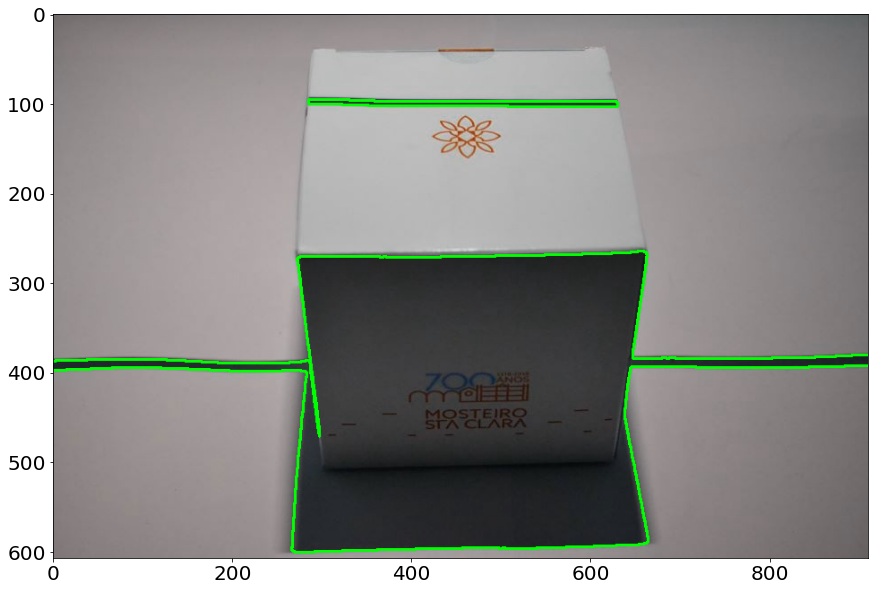

In [72]:
# Then, use findContours to get the contours. You can adjust the parameters for better performance.

contours2, _ = cv2.findContours(laplacian, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cont2 = cv2.drawContours(img_shadow_plane, contours2, -1, (0,255,0), 2)

plt.imshow(cont2, cmap='gray')
plt.show()

Here, we defined some variables in order to filtrate some of the overlapping lines obtained with findContours.
Basically, what happens is that we select 3 points on top of the shadow line: the highest left point, the highest right point and the highest middle point.

Also, xl, yl, xr, yr, xm, ym are defined with the value -1 and width+1 because they are supposed to represent pixels,
and by assigning the value -1 and width + 1, there is no risk of actually missing a point value because these values do not belong in the image.

In order to regularize the obtained pixels we assure that the 
(xm, ym) pixel refers to the line in the upper plane of our image, 
(xl, yl) to the left line on the lower plane and (xr, yr) to the right line 
on the lower plane

In [73]:
width = img_shadow_plane.shape[1]
mid_point = math.ceil(width/2)

xl=width+1
yl=width+1
xr=-1
yr=width+1
xm=-1
ym=width+1


for contour in contours2:
    for point in contour:
        if point[0][0] <= xl:
            if point[0][0] == xl:
                if point[0][1] <= yl:
                    xl = point[0][0]
                    yl = point[0][1]
            else:
                xl = point[0][0]
                yl = point[0][1]
        if point[0][0] >= xr:
            if point[0][0] == xr:
                if point[0][1] <= yr:
                    xr = point[0][0]
                    yr = point[0][1]
            else:
                xr = point[0][0]
                yr = point[0][1]
        if (mid_point-5 < point[0][0] < mid_point+5) and point[0][1] < ym:
            xm = point[0][0]
            ym = point[0][1]


Now, it's only necessary to obtain the A, B, C, D and a, b, c, d variables of each pixel plane
in order to obtain the pixel values in our world coordinate. For this, we only need to add the value
of a selected plane which, in our case, was z=10 for (x10, y10) and z=0 for the other 2 points.


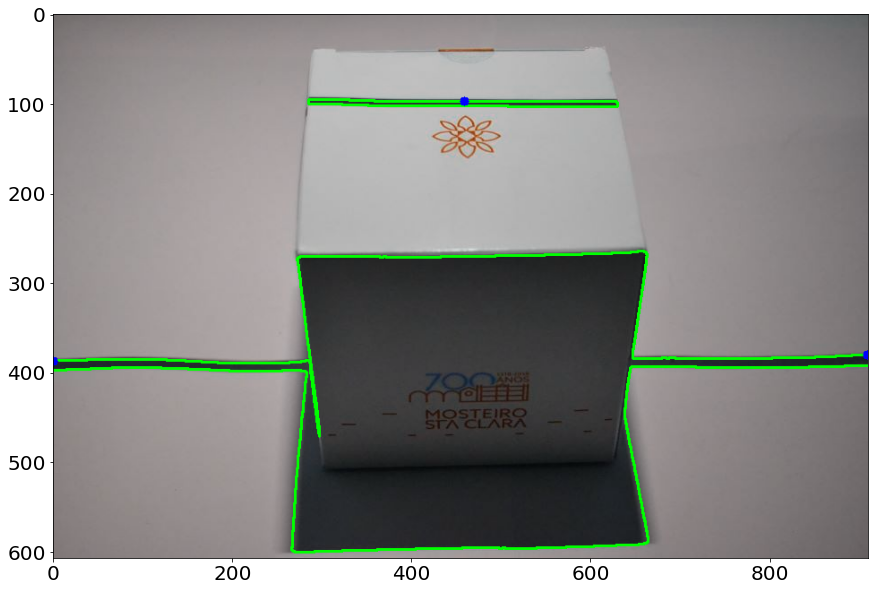

In [74]:
#1º Pixel
#(xm,ym) it's in the plane z1=10

cv2.circle(img_shadow_plane, (xm,ym), 5, (0,0,255), -1)

A1 = PPMatrix[2][0]*xm - PPMatrix[0][0]
B1 = PPMatrix[2][1]*xm - PPMatrix[0][1]
C1 = PPMatrix[2][2]*xm - PPMatrix[0][2]
D1 = PPMatrix[0][3] - PPMatrix[2][3]*xm

a1 = PPMatrix[2][0]*ym - PPMatrix[1][0]
b1 = PPMatrix[2][1]*ym - PPMatrix[1][1]
c1 = PPMatrix[2][2]*ym - PPMatrix[1][2]
d1 = PPMatrix[1][3] - PPMatrix[2][3]*ym

z1=-10/square_size
x1,y1 = symbols('x1 y1')
eq1 = Eq(A1*x1 + B1*y1 + C1*z1 - D1, 0)
eq2 = Eq(a1*x1 + b1*y1 + c1*z1 - d1, 0)

sol1 = solve((eq1,eq2), (x1,y1))

#2º Pixel
#(xl,yl) it's in the plane z2=0

cv2.circle(img_shadow_plane, (xl,yl), 5, (0,0,255), -1)

A2 = PPMatrix[2][0]*xl - PPMatrix[0][0]
B2 = PPMatrix[2][1]*xl - PPMatrix[0][1]
C2 = PPMatrix[2][2]*xl - PPMatrix[0][2]
D2 = PPMatrix[0][3] - PPMatrix[2][3]*xl

a2 = PPMatrix[2][0]*yl - PPMatrix[1][0]
b2 = PPMatrix[2][1]*yl - PPMatrix[1][1]
c2 = PPMatrix[2][2]*yl - PPMatrix[1][2]
d2 = PPMatrix[1][3] - PPMatrix[2][3]*yl

z2=0
x2,y2 = symbols('x2 y2')
eq3 = Eq(A2*x2 + B2*y2 + C2*z2 - D2, 0)
eq4 = Eq(a2*x2 + b2*y2 + c2*z2 - d2, 0)

sol2 = solve((eq3,eq4), (x2,y2))

#3º Pixel
#(xr,yr) it's in the plane z2=0

cv2.circle(img_shadow_plane, (xr,yr), 5, (0,0,255), -1)


A3 = PPMatrix[2][0]*xr - PPMatrix[0][0]
B3 = PPMatrix[2][1]*xr - PPMatrix[0][1]
C3 = PPMatrix[2][2]*xr - PPMatrix[0][2]
D3 = PPMatrix[0][3] - PPMatrix[2][3]*xr

a3 = PPMatrix[2][0]*yr - PPMatrix[1][0]
b3 = PPMatrix[2][1]*yr - PPMatrix[1][1]
c3 = PPMatrix[2][2]*yr - PPMatrix[1][2]
d3 = PPMatrix[1][3] - PPMatrix[2][3]*yr

z3=0
x3,y3 = symbols('x3 y3')
eq5 = Eq(A3*x3 + B3*y3 + C3*z3 - D3, 0)
eq6 = Eq(a3*x3 + b3*y3 + c3*z3 - d3, 0)

sol3 = solve((eq5,eq6), (x3,y3)) 

plt.imshow(img_shadow_plane)
plt.show()

Now, we have 3 points: (x1, y1, z1); (x2, y2, z2); (x3, y3, z3);
which is the number of points we need to calculate the shadow plane!
This means that we only need to do some equation solving to obtain the A, B and C
plane variables (to the variable D it is going to be attributed a constant value of 1).

In [75]:
varA, varB, varC= symbols('A B C')

#D is considered = 1 to calculate the shadow plane 
D = 1

eqABC1 = Eq(varA*sol1[x1] + varB*sol1[y1] + varC*z1, D)
eqABC2 = Eq(varA*sol2[x2] + varB*sol2[y2] + varC*z3, D)
eqABC3 = Eq(varA*sol3[x3] + varB*sol3[y3] + varC*z3, D)
solABC = solve((eqABC1, eqABC2, eqABC3), (varA, varB, varC))
A, B, C = solABC[varA], solABC[varB], solABC[varC]

print('(A, B, C, D)')
print('{}, {}, {}, {})'.format(A, B, C, D))

(A, B, C, D)
0.164415406896803, -0.00315162726832304, -0.0417105186737645, 1)


In [76]:
#This function calculates the 3D coordinates given the Perspective Projection Matrix (PPM), the plane coefficients (A, B, C, D) and the
#pixel point we want to convert (i, j)
def calculate3DPointCoords(PPM, i, j, A, B, C, D):
    x_var, y_var, z_var = symbols('X Y Z')
    calcX = Eq((PPM[2][0] * i - PPM[0][0]) * x_var + (PPM[2][1]*i - PPM[0][1]) * y_var + (PPM[2][2]*i - PPM[0][2]) * z_var - PPM[0][3] + PPM[2][3]*i, 0)
    calcY = Eq((PPM[2][0] * j - PPM[1][0]) * x_var + (PPM[2][1]*j - PPM[1][1]) * y_var + (PPM[2][2]*j - PPM[1][2]) * z_var - PPM[1][3] + PPM[2][3]*j, 0)
    calcZ = Eq(A * x_var + B * y_var + C * z_var - D, 0)
    sol = solve((calcX, calcY, calcZ), (x_var, y_var, z_var))

    return sol[x_var], sol[y_var], -sol[z_var]

Here, we get a new image with the same shadow plane and apply findContours to obtain the line representation of that plane.

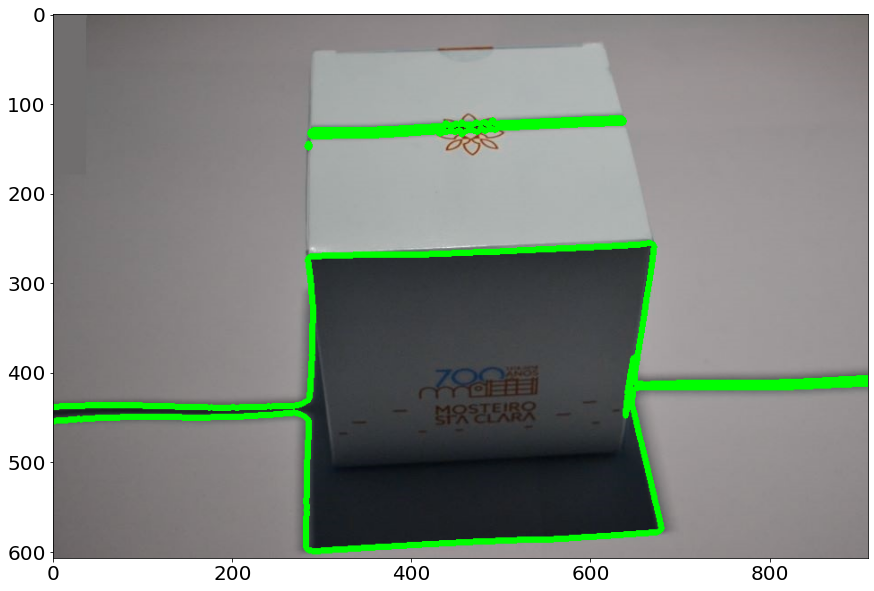

In [77]:
# Gray image
img_to_represent = cv2.imread(os.path.join(line_detection_path, 'img1.JPG'))
gray_rep = cv2.cvtColor(img_to_represent, cv2.COLOR_BGR2GRAY)

gray_rep = cv2.GaussianBlur(gray_rep, (5,5), 0)

# Threshold
low_threshold = 80
high_threshold = 120 #low_threshold * 3
_,thresh_rep = cv2.threshold(gray_rep, low_threshold, high_threshold, cv2.THRESH_BINARY)
thresh_rep = 255 - thresh_rep

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(2, 2))

# Remove noise
thresh_rep = cv2.erode(thresh_rep, kernel=(1,1), iterations=2)

# Laplacian
laplacian_rep = cv2.Laplacian(thresh_rep, cv2.CV_8U)


contours, _ = cv2.findContours(laplacian_rep, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cont = cv2.drawContours(img_to_represent, contours, -1, (0,255,0), 5)
plt.imshow(cont, cmap='gray')
plt.show()

After having found the contours of the new image, it is now possible to calculate the height map of the object using the
shadow plane coefficients (A, B, C, D) found earlier.

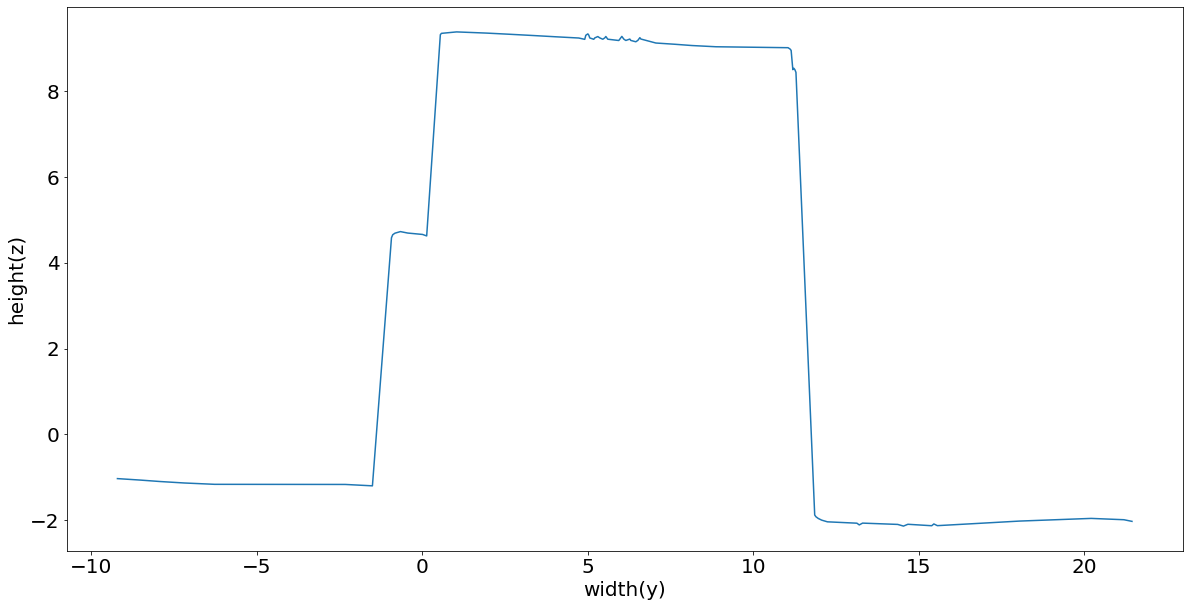

In [78]:
# Find highest pixel in contours
height = laplacian_rep.shape[0]
maximum = np.ones(width, dtype=int)*height

for contour in contours:
    for point in contour:
        i = point[0][0]
        j = point[0][1]
        if maximum[i] > j:
           maximum[i] = j

# Compress maximum array and calculate 3D points into heightMap
heightMap = []
curr_max = -1

for i, max_val in enumerate(maximum):
    if max_val != curr_max and max_val != height:
        heightMap.append(calculate3DPointCoords(PPMatrix, i, max_val, A, B, C, D))
        curr_max = max_val

# Create a height histogram with calculated height map
histHeight = [0.0, 1.0] * len(heightMap)
histHeight = np.array(histHeight).reshape((len(heightMap), 2))

for i, point in enumerate(heightMap):
    histHeight[i][0] = point[2] * square_size
    histHeight[i][1] = point[1] * square_size

plt.plot(histHeight[:,1], histHeight[:,0])
plt.xlabel('width(y)')
plt.ylabel('height(z)')
plt.show()

References
- https://docs.opencv.org/3.3.0/dc/dbb/tutorial_py_calibration.html
- https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html
- https://docs.opencv.org/3.3.0/d9/d0c/group__calib3d.html
